In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
batch_size = 32
image_size_x = 256
image_size_y = 256
channels = 3
epochs = 50

In [3]:
# I am using the dataset from Coffee Leaf Diseases and set configurations for the train dataset
# Because I need to put all the dataset into one format with the same size.
dataset = keras.preprocessing.image_dataset_from_directory(
    "./data/coffee_leaf_disease/train",
    seed = 123, # 0 # 42
    shuffle = True,
    image_size = (image_size_x, image_size_y),
    batch_size = batch_size
)

Found 1264 files belonging to 4 classes.


In [4]:
# I print the name of the classes
class_names = dataset.class_names
class_names

['miner', 'nodisease', 'phoma', 'rust']

In [5]:
# 1264/32 = 39.5 = 40
len(dataset)

40

In [6]:
train_size = 0.8
len(dataset) * train_size

32.0

In [7]:
train_ds = dataset.take(13)
len(train_ds)

13

In [8]:
test_ds = dataset.skip(13)
len(test_ds)

27

In [9]:
val_size = 0.1
len(dataset) * val_size

4.0

In [10]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [11]:
test_ds = test_ds.skip(1)
len(test_ds)

26

In [12]:
# I code get_dataset_partitions_tf function 
# to get the train, validation and test datasets (80%, 10%, 10%)

def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds), len(val_ds), len(test_ds)

(32, 4, 4)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = keras.Sequential([
  layers.Resizing(image_size_x, image_size_y),
  layers.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (batch_size, image_size_x, image_size_y, channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

d:\Enviroment\computer_vision\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - accuracy: 0.3194 - loss: 1.3805 - val_accuracy: 0.3125 - val_loss: 1.3745
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 690ms/step - accuracy: 0.3158 - loss: 1.3705 - val_accuracy: 0.4609 - val_loss: 1.3251
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 719ms/step - accuracy: 0.4256 - loss: 1.2755 - val_accuracy: 0.4609 - val_loss: 1.1185
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step - accuracy: 0.4344 - loss: 1.1339 - val_accuracy: 0.4609 - val_loss: 1.0456
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step - accuracy: 0.5120 - loss: 1.0260 - val_accuracy: 0.4844 - val_loss: 1.0788
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 704ms/step - accuracy: 0.4980 - loss: 1.0095 - val_accuracy: 0.5625 - val_loss: 0.9230
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 0.5990 - loss: 0.9104 - val_accuracy: 0.6172 - val_loss: 0.8823
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 681ms/step - accuracy: 0.6139 - loss: 0.8783 - val_accu

In [23]:
scores = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 0.0198


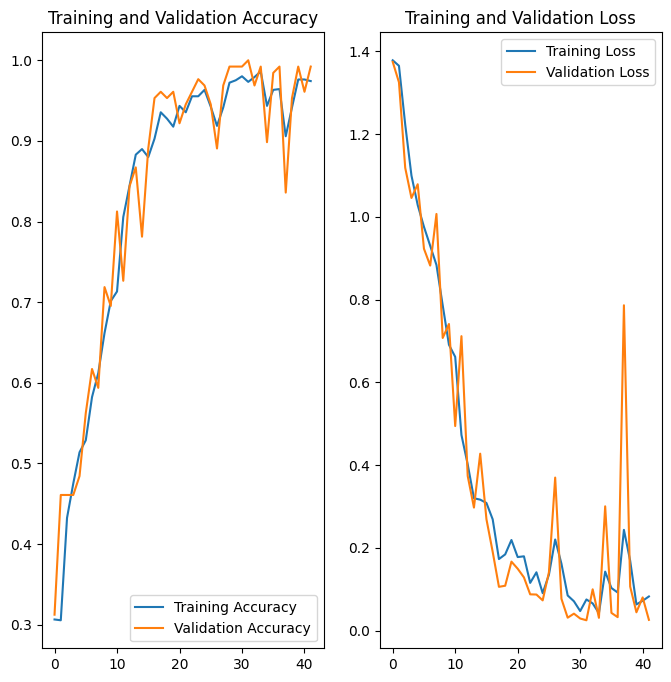

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: nodisease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
predicted label: nodisease


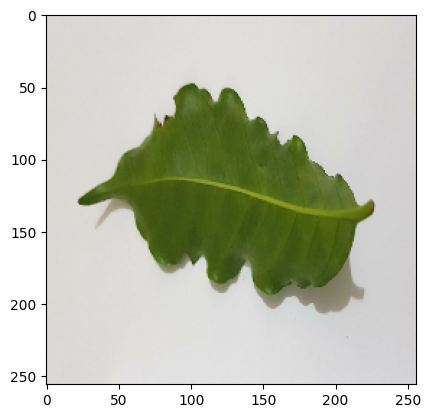

In [25]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


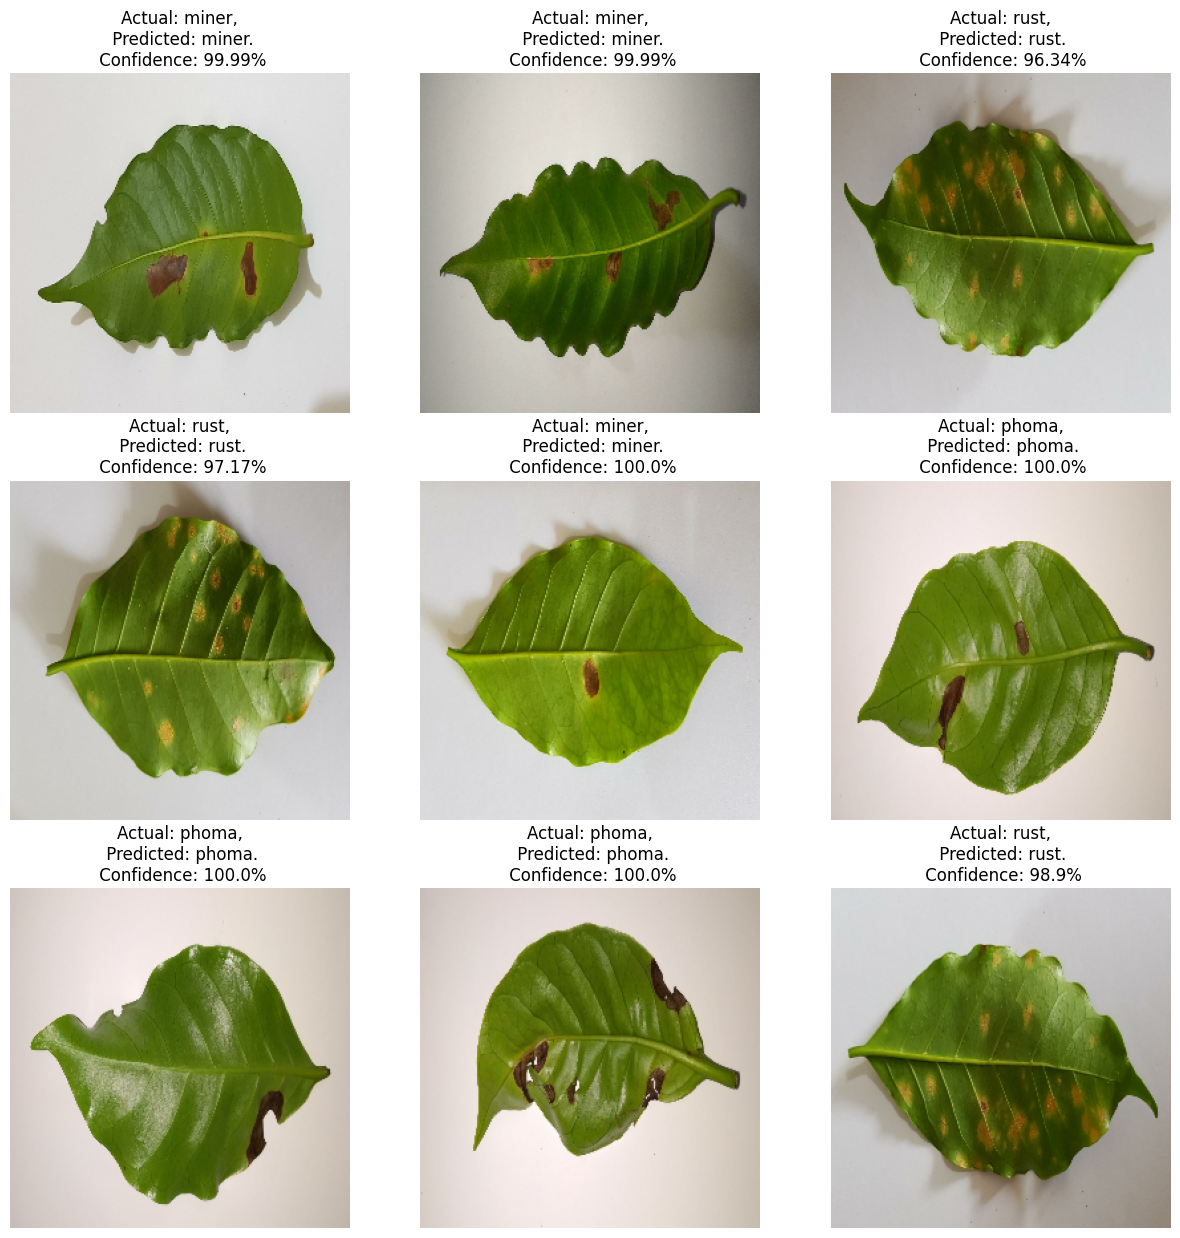

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [32]:
model_version = 5
model_name = 'cnn'
model.save("../models/model_{}_v{}".format(model_name, model_version))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


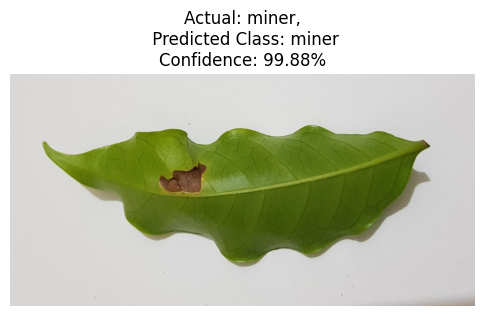

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


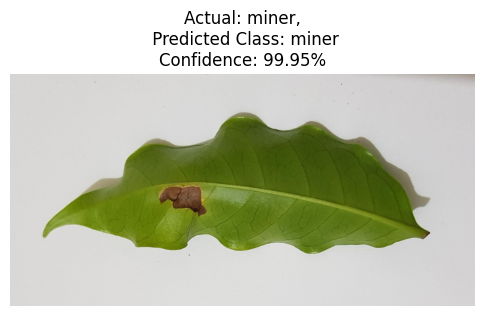

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


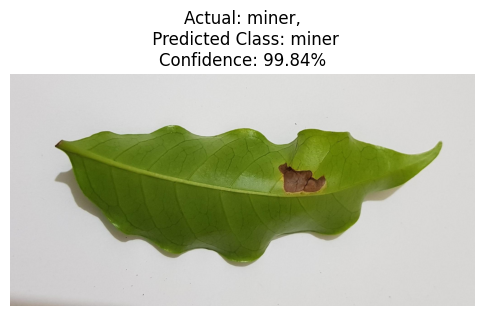

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


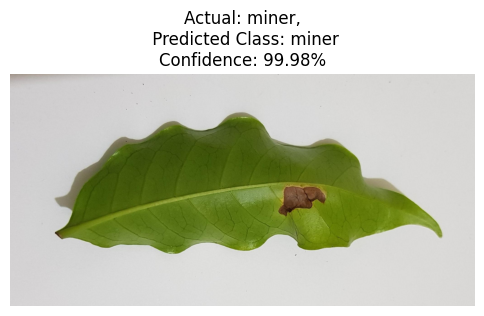

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


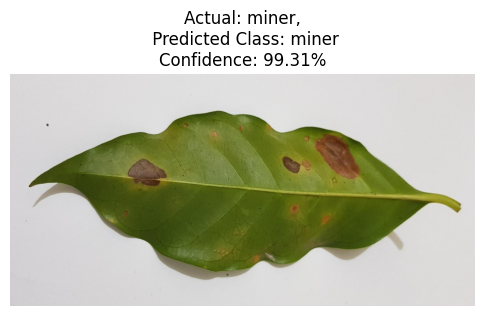

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


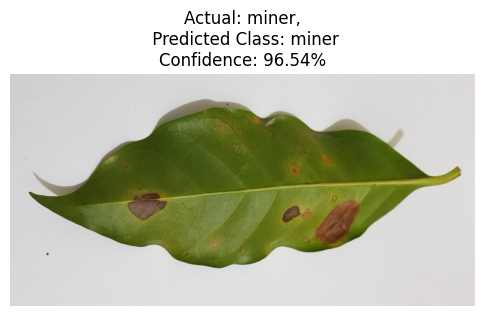

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


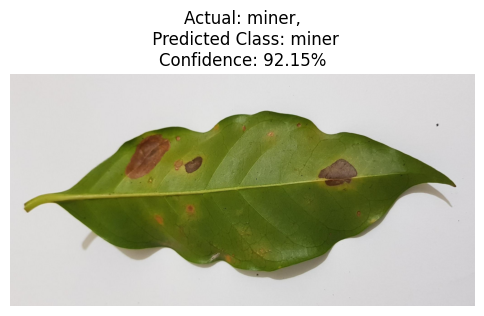

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


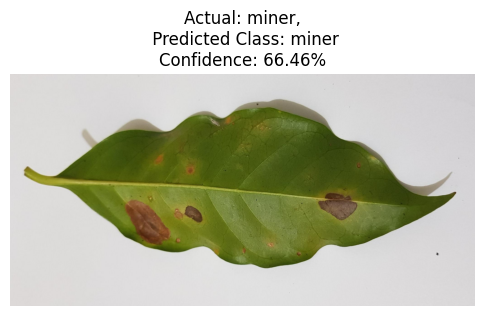

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


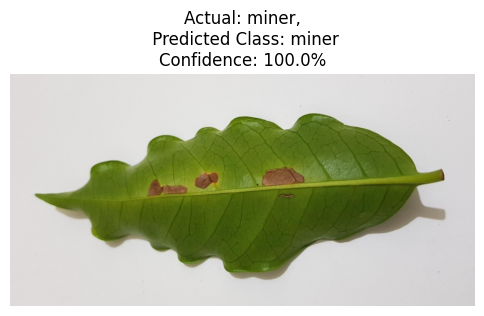

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


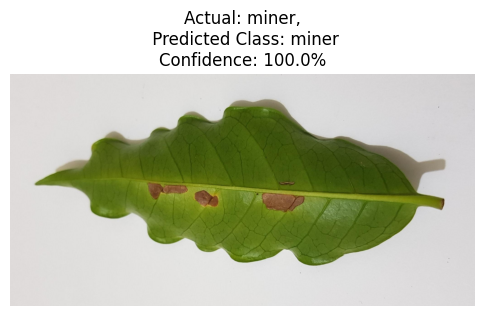

In [42]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


model = tf.keras.models.load_model(r"./models/model_5.h5")


class_names = ['miner', 'nodisease', 'phoma', 'rust']


miner ="./data/coffee_leaf_disease/test/miner"
nodisease= "./data/coffee_leaf_disease/test/nodisease"
phoma="./data/coffee_leaf_disease/test/phoma"
rust="./data/coffee_leaf_disease/test/rust"
max_iterations=10
def classificator(image_dirteste,actual_class,max_iterations):
    
    iteration_count = 0  
    image_dirteste = image_dirteste
    for filename in os.listdir(image_dirteste):
           
            if filename.endswith('.jpg'):
      
                image_path = os.path.join(image_dirteste, filename)

     
                predicted_class, confidence = predict(model, image_path, class_names)
                Actual: {actual_class}

                plt.figure(figsize=(6, 6))
                img = plt.imread(image_path)
                plt.imshow(img)
                plt.title(f"Actual: {actual_class},\n Predicted Class: {predicted_class}\nConfidence: {confidence}%")
                plt.axis('off')
                plt.show()
            
                iteration_count += 1
                
                
            if iteration_count >= max_iterations:
                break

                
classificator(miner,'miner',10)